In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [187]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library import HGate, XGate, YGate, ZGate, SGate
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

In [150]:
# (i) Build a simple noise model with depolarizing noise
def construct_noise_model(qubits, noise_prob):
    noise_model = NoiseModel()

    # incorporate depolarizing error on PauliX gates
    error = depolarizing_error(noise_prob, 1)
    noise_model.add_quantum_error(error, ['x'], qubits)

    noise_model.add_quantum_error(error, ['y'], qubits)
    noise_model.add_quantum_error(error, ['z'], qubits)

    # construct a noisy simulator using the noise model
    noisy_sim = AerSimulator(noise_model=noise_model)

    return noise_model, noisy_sim

In [151]:
# (ii) Create different circuits to test your noise models and choose the observable to measure
# Clifford gates from which circuits can be generated
gate_population = [
    HGate, XGate, YGate, ZGate, SGate
]

# randomized benchmarking uses circuits composed of various Clifford gates and the full inverse,
# such that the zero-noise expectation value should simply be 0 if no errors occur
def randomized_benchmarking_circuit(n_gates):
    qcirc = QuantumCircuit(1)

    # random shuffled sample of gates used for circuit
    gate_sample_1q = np.random.choice(gate_population, n_gates)
    shuffled_gates = np.random.permutation(gate_sample_1q)

    # append original gates to circuit
    for gate in shuffled_gates:
        qcirc.append(gate(), [0])
    
    # append inverse of current circuit so that final qubit state should be left unchanged under no errors
    qcirc = qcirc.compose(qcirc.inverse())
    
    return qcirc

In [152]:
# (iii) Apply the unitary folding method
def benchmark_noise(circuit, method, base_noise_level, max_depth_scaling, n_qubits=1):
    qubits = [0 for i in range(n_qubits)]

    # increment scale factor by odd numbers for gate folding methods
    scale_factor_step_size = 1 if method == "circuit" else 2

    # noise model based on the base noise level
    noise_model, noisy_sim = construct_noise_model(qubits, base_noise_level)

    noise_data = {}
    for scale_factor in range(1, max_depth_scaling, scale_factor_step_size):
        # quantum circuit with the given observable
        noisy_circuit = QuantumCircuit(n_qubits)

        # unitary folding parameters
        k = round(circuit.depth() * (scale_factor - 1)/2)
        n = int(np.floor(k/circuit.depth()))
        s = np.mod(k, circuit.depth())
        
        if method == "circuit": # full circuit folding
            # start with original circuit
            noisy_circuit = noisy_circuit.compose(circuit)

            # place barrier to prevent gate reordering
            noisy_circuit.barrier()

            # add n integer foldings of the entire circuit and its inverse
            for i in range(n):
                noisy_circuit = noisy_circuit.compose(circuit, qubits)
                noisy_circuit = noisy_circuit.compose(circuit.inverse(), qubits)

                noisy_circuit.barrier()

            # get a partial circuit of the last s operations
            partial_circuit = circuit.copy()
            while partial_circuit.depth() > circuit.depth() - s:
                partial_circuit.data.pop(0)
            
            # add a folding of the partial circuit and its inverse
            noisy_circuit = noisy_circuit.compose(partial_circuit)
            noisy_circuit = noisy_circuit.compose(partial_circuit.inverse())

            noisy_circuit.barrier()
        elif "gate" in method: # individual gate(/layer) folding
            if method == "gate-left": # fold first s gates
                S = [i for i in range(s)]
            elif method == "gate-right": # fold last s gates
                S = [i for i in range(circuit.depth() - s, circuit.depth())]
            elif method == "gate-random": # fold s random gates
                S = np.random.randint(noisy_circuit.depth(), size=s)

            # we will replace the circuit data with individually-folded instructions
            noisy_circuit_data = []


            for i in range(len(circuit.depth())):
                # get the circuit instruction at this position and make a new instruction corresponding to its inverse
                circuit_instruction = circuit.data[i]
                circuit_instruction_inverse = CircuitInstruction(circuit_instruction.operation.inverse(), circuit_instruction[1], circuit_instruction[2])

                # append the original instruction itself
                noisy_circuit_data.append(circuit_instruction)

                # append n or n+1 folds of the instruction and its inverse,
                # which should evaluate to the identity in the zero-noise limit
                for j in range(n if i in S else n+1):
                    noisy_circuit_data.append(circuit_instruction)
                    noisy_circuit_data.append(circuit_instruction_inverse)

                    noisy_circuit.barrier()
            
            # replace the noisy circuit data with the new gate(/layer)-folded data
            noisy_circuit.data = noisy_circuit_data

        # measure all qubits
        noisy_circuit.measure_all()

        # transpile circuit with no optimization to preserve RB circuit and unitary folding
        noisy_circuit_transpiled = transpile(noisy_circuit, noisy_sim, optimization_level=0)
        result = noisy_sim.run(noisy_circuit_transpiled).result()
        counts = result.get_counts(noisy_circuit_transpiled)

        # save counts in dictionary for each scale factor
        noise_data[scale_factor] = counts

    return noise_data

def calculate_expectation_values(noise_data):
    # create lists of the scale factors and expectation values
    scale_factors = np.array(list(noise_data.keys()))
    expectation_values = np.array([])

    for counts in list(noise_data.values()):
        # since the measurement values are either 0 or 1,
        # the expectation value is equal to the probability of measuring 1
        expectation_value = counts["1"]/(counts["0"]+counts["1"])
        expectation_values = np.append(expectation_values, expectation_value)
    
    return scale_factors, expectation_values

def calculate_probabilities(noise_data, state):
    # create lists of the scale factors and probabilities
    scale_factors = np.array(list(noise_data.keys()))
    probabilities = np.array([])

    for counts in list(noise_data.values()):
        # calculate the fraction of counts in the desired state
        probability = counts[str(state)]/(counts["0"]+counts["1"])
        probabilities = np.append(probabilities, probability)
    
    return scale_factors, probabilities

In [153]:
# (iv) Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
def zero_noise_extrapolation(scale_factors, expectation_values, method, method_options={}):
    zero_noise_expval = -1

    match method:
        case "linear":
            a, b = np.polyfit(scale_factors, expectation_values, 1)
            fit_params = [a, b]
            zero_noise_expval = b # when x = 0, the line reduces to its constant term (y-intercept)
        case "polynomial":
            a, b, c = np.polyfit(scale_factors, expectation_values, 2)
            fit_params = [a, b, c]
            zero_noise_expval = c # when x = 0, the polynomial reduces to its constant term (vertical shift)
        case "exponential":
            # because we expect the noise (and thus, the expectation value) to grow with circuit scale
            # but still have a horizontal asymptote, so we reflect the usual exponential function about both axes
            exponential_function = lambda x, a, b, c: -a * np.exp(-b * x) + c
            popt, _ = curve_fit(exponential_function, scale_factors, expectation_values)
            a, b, c = popt
            fit_params = [a, b, c]
            zero_noise_expval = -a + c # when x = 0, the polynomial reduces to its (negative) base plus its constant term (vertical shift)

    return scale_factors, expectation_values, zero_noise_expval, fit_params

Mitigated zero-noise expectation value (exponential extrapolation): 0.12183649006082542
Unmitigated zero-noise expectation value: 0.11328125
Expected zero-noise expectation value: 0


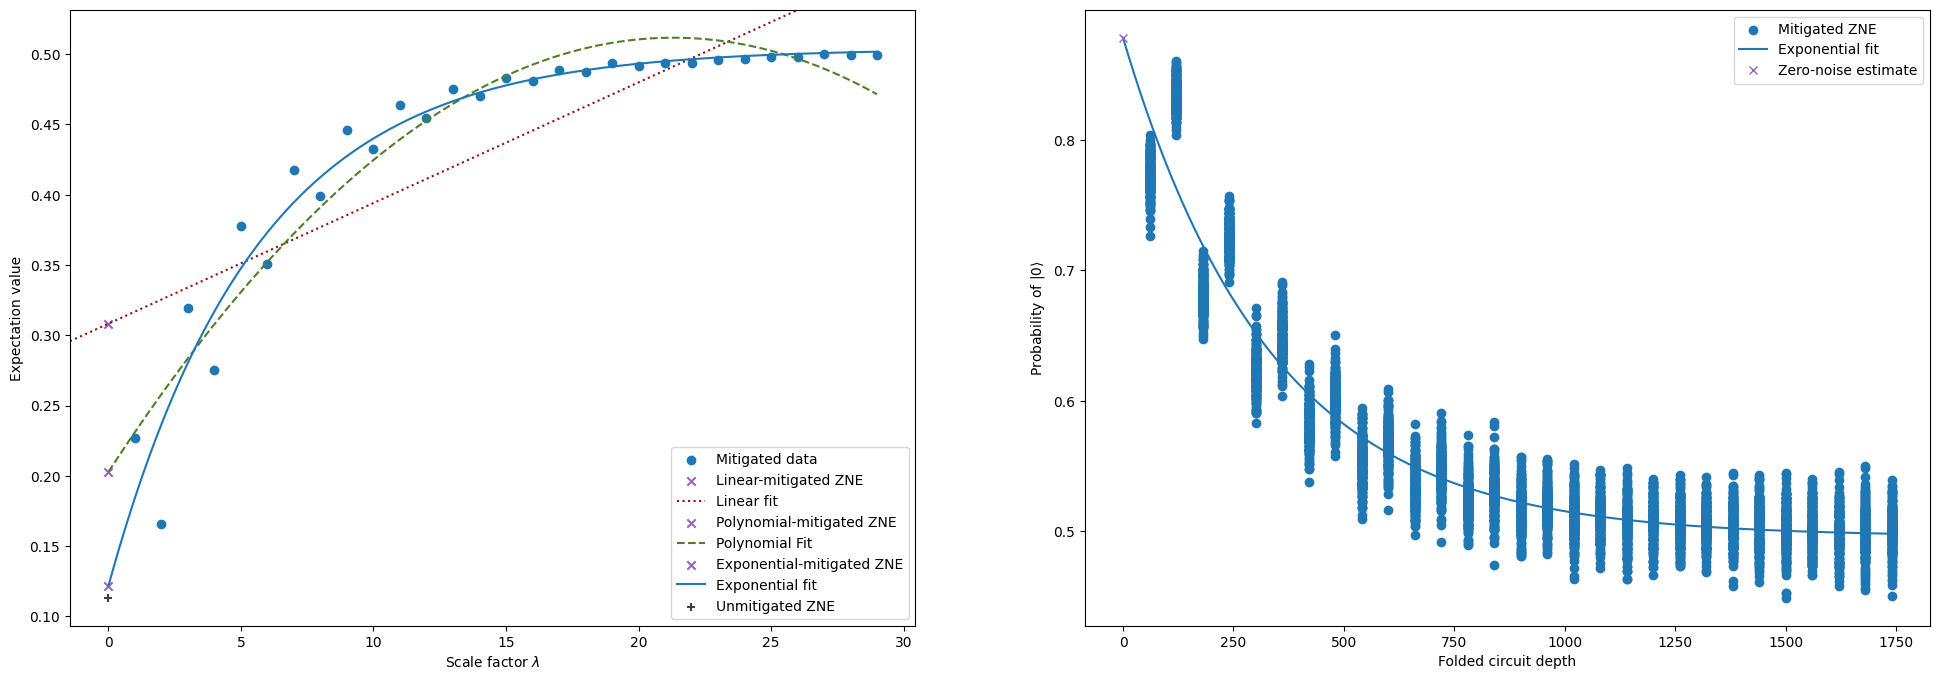

In [210]:
# (v) Compare mitigated and unmitigated results
base_noise_level = 0.01 # smaller base noise level gives us a better estimate close to the noise floor
max_depth_scaling = 30 # max reasonable: int(np.ceil(1/base_noise_level)-1)

# RB circuit using Clifford gates
test_circuit = randomized_benchmarking_circuit(max_depth_scaling)

# store the raw collected data 
mitigated_scale_factors = []
mitigated_expectation_values = []
grouped_data = {}

for i in range(200):
    # benchmark the noise for the circuit using the circuit folding method with a given base noise level and a maximum depth scaling, lambda
    sample_noise_data = benchmark_noise(test_circuit, "circuit", base_noise_level, max_depth_scaling)

    # calculate expectation values of the circuit for each scale factor - these should be 0 if no noise is present
    sample_mitigated_scale_factors, sample_mitigated_expectation_values = calculate_expectation_values(sample_noise_data)
    
    # save the raw data
    mitigated_scale_factors.extend(sample_mitigated_scale_factors)
    mitigated_expectation_values.extend(sample_mitigated_expectation_values)
    
    # group the values by their scale factor
    for s in range(len(sample_mitigated_scale_factors)):
        if sample_mitigated_scale_factors[s] in grouped_data.keys():
            grouped_data[sample_mitigated_scale_factors[s]].extend([sample_mitigated_expectation_values[s]])
        else:
            grouped_data[sample_mitigated_scale_factors[s]] = [sample_mitigated_expectation_values[s]]

# combine the data based on scale factors, replacing raw points with the mean for each scale factor
mitigated_scale_factors_combined = list(grouped_data.keys())
mitigated_expectation_values_combined = [np.mean(group) for group in list(grouped_data.values())]

zero_noise_expvals_mitigated = {"linear": -1, "polynomial": -1, "exponential": -1}
fit_params = {"linear": [], "polynomial": [], "exponential": []}
for extrapolation_method in ["linear", "polynomial", "exponential"]:
    try:
        # perform ZNE using each extrapolation method
        scale_factors, expectation_values, zero_noise_expval_mitigated, mitigated_fit_params = zero_noise_extrapolation(mitigated_scale_factors, mitigated_expectation_values, extrapolation_method, method_options={})
        zero_noise_expvals_mitigated[extrapolation_method] = zero_noise_expval_mitigated
        fit_params[extrapolation_method] = mitigated_fit_params
    except:
        # this can occur if the fit just isn't possible, for example with very grainy data or a high base noise level
        zero_noise_expvals_mitigated[extrapolation_method] = None

        print(extrapolation_method, f"Could not perform a(n) {extrapolation_method} fit to data")

############################################################################################

# we also want to plot the relationship betwen the folded circuit depth and the probability of measuring 0
mitigated_folded_circuit_depths = []
mitigated_probabilities_0 = []

for i, mitigated_scale_factor in enumerate(mitigated_scale_factors):
    # the same unitary parameters used during the original unitary folding process
    k = round(test_circuit.depth() * (mitigated_scale_factor - 1)/2)
    n = int(np.floor(k/test_circuit.depth()))
    s = np.mod(k, test_circuit.depth())

    # calculate the folded circuit depths - same for both the circuit folding and all three gate(/layer) folding methods!
    folded_circuit_depth = test_circuit.depth() * (2*n + 1) + 2*s
    mitigated_folded_circuit_depths.append(folded_circuit_depth)

    # since a qubit is either in the 0 or 1 state, the expectation value equals the probability of measuring a 0,
    # so the probability of measuring a 0 is simply equal to: 1 - expectation_value
    probability_0 = 1 - mitigated_expectation_values[i]
    mitigated_probabilities_0.append(probability_0)

############################################################################################

# copy the test circuit and add measurements without any folding (unmitigated procedure)
unmitigated_circuit = test_circuit.copy()
unmitigated_circuit.measure_all()

# use the same noise model
unmitigated_noise_model, unmitigated_circuit_sim = construct_noise_model([0], base_noise_level)
unmitigated_circuit_transpiled = transpile(unmitigated_circuit, unmitigated_circuit_sim, optimization_level=0)
unmitigated_result = unmitigated_circuit_sim.run(unmitigated_circuit_transpiled).result()
unmitigated_counts = unmitigated_result.get_counts(unmitigated_circuit_transpiled)

# the expectation value is again the fraction of 1 measurements, except now we do not use extrapolation,
# as though there were no noises present at all
zero_noise_expval_unmitigated = unmitigated_counts["1"]/(unmitigated_counts["0"]+unmitigated_counts["1"])

############################################################################################

print(f"Mitigated zero-noise expectation value (exponential extrapolation):", zero_noise_expvals_mitigated["exponential"])
print(f"Unmitigated zero-noise expectation value:", zero_noise_expval_unmitigated)
print(f"Expected zero-noise expectation value: 0")

############################################################################################

# plotting time!

fig, ax = plt.subplots(1, 2, figsize=(24, 8))

##############################################

# means of the raw data collected using ZNE mitigation
ax[0].scatter(mitigated_scale_factors_combined, mitigated_expectation_values_combined, label="Mitigated data")

for extrapolation_method in ["linear", "polynomial", "exponential"]:
    if zero_noise_expvals_mitigated[extrapolation_method] == None:
        continue

    # plot the ZNE estimate for each extrapolation method
    ax[0].scatter(0, zero_noise_expvals_mitigated[extrapolation_method], c="#9467bd", marker="x", label=f"{extrapolation_method.title()}-mitigated ZNE")

    # plot each of the fitted curves used for extrapolation
    match extrapolation_method:
        case "linear":
            ax[0].axline((0, fit_params["linear"][1]), slope=fit_params["linear"][0], linestyle=":", c="#950e0e", label=f"{extrapolation_method.title()} fit")
        case "polynomial":
            fit_polynomial = np.poly1d(fit_params["polynomial"])
            sample_points = np.linspace(0, max(mitigated_scale_factors_combined), len(mitigated_scale_factors))
            ax[0].plot(sample_points, fit_polynomial(sample_points), "--", c="#508026", label=f"{extrapolation_method} fit".title())
        case "exponential":
            fit_exponential = lambda x, a, b, c: -a * np.exp(-b * x) + c
            sample_points = np.linspace(0, max(mitigated_scale_factors_combined), len(mitigated_scale_factors))
            ax[0].plot(sample_points, fit_exponential(sample_points, *fit_params["exponential"]), "-", label=f"{extrapolation_method.title()} fit")

# plot the unmitigated expectation value at the "zero-noise" limit
ax[0].scatter(0, zero_noise_expval_unmitigated, c="#3f3f3f", marker="+", label="Unmitigated ZNE")

ax[0].set_xlabel(r"Scale factor $\lambda$")
ax[0].set_ylabel(r"Expectation value")

ax[0].legend()

##############################################

# mitigated_folded_circuit_depths = mitigated_folded_circuit_depths/max(mitigated_folded_circuit_depths)

# means of the raw data collected using ZNE mitigation
ax[1].scatter(mitigated_folded_circuit_depths, mitigated_probabilities_0, label="Mitigated ZNE")

# we expect that probability of measuring a 0 to decrease with the (folded) circuit depth,
# so we fit the data to an exponential decay curve
exponential_curve = lambda x, a, b, c: a * np.exp(-b * x) + c

# for the purpose of fitting, we scale all the depths to be between 0 and 1, and then rescale afterwards
# this is because the scipy curve_fit method doesn't work very well for x,y data which are many orders of magnitude off
sample_points_reduced = np.linspace(0, 1, len(mitigated_folded_circuit_depths))
popt, _ = curve_fit(exponential_curve, mitigated_folded_circuit_depths/max(mitigated_folded_circuit_depths), mitigated_probabilities_0)
a, b, c = popt

sample_points_rescaled = sample_points_reduced * max(mitigated_folded_circuit_depths)
fit_data_rescaled = exponential_curve(sample_points_rescaled, a, b/max(mitigated_folded_circuit_depths), c)

ax[1].plot(sample_points_rescaled, fit_data_rescaled, "-", label=f"Exponential fit")
ax[1].plot(0, exponential_curve(0, *popt), "x", label=f"Zero-noise estimate", c="#9467bd")

ax[1].set_xlabel(r"Folded circuit depth")
ax[1].set_ylabel(r"Probability of $|0\rangle$")

ax[1].legend()

############################################################################################

plt.show()